# Poisson rSLDS 
## Behaving dataset
## Stim is as cue, system should come back to rest before lift 
## Fitting model from cue to grab, k=3

In [340]:
import ssm
from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from real_spike.utils import *

from scipy.ndimage import gaussian_filter1d

import random
import h5py

import fastplotlib as fpl
from ipywidgets import IntSlider, VBox, Layout, Select, HBox

from PIL import Image
%matplotlib inline

In [2]:
path = f"/home/clewis/repos/realSpike/data/behavior/rb50_20250125/"

In [3]:
video_path =  Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/videos/")

# Get data

In [4]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/MAT_FILES/rb50_20250125_datastruct_pt3.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_cue_rec_time', 'aligned_laser_rec_time', 'any', 'chan_spk', 'cue', 'cue_rec_time', 'cue_trial_time', 'depth_spk', 'field_id', 'field_size', 'full_field', 'grab', 'grab_ms', 'laser', 'laser_rec_time', 'laser_trial_time', 'lift', 'lift_ms', 'lift_rec_time', 'mouth', 'mouth_ms', 'no_success', 'pattern_fill', 'pattern_id', 'pattern_xy', 'plift', 'plift_ms', 'single', 'spikes_raw_cue', 'spikes_raw_cue_extended', 'spikes_raw_laser', 'spikes_raw_lift', 'totTime', 'trial_start']>


# Plot the patterns

In [5]:
# visualize the patterns again
pattern_ids = list(np.unique(data['pattern_id'][:]))
len(pattern_ids)

30

In [6]:
from scipy.ndimage import zoom

In [7]:
reshape_size = 12

In [8]:
all_patterns = list()

for p_id in pattern_ids[3:]:
    ix = np.where(data['pattern_id'][:] == p_id)[1][0].astype(np.int32)
    pattern = np.zeros((data['pattern_xy'][0][ix].astype(np.int32), data['pattern_xy'][1][ix].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = f[data['pattern_fill'][ix, 0]]
    for x, y in zip(object_ref[0, :], object_ref[1, :]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    all_patterns.append(pattern)


In [9]:
len(all_patterns)

27

# Get single-reach trials

In [10]:
stim_idxs = np.where(data["pattern_id"][:] > 2)[1]
single_reach_idxs = np.where(data["single"][:, 0] == 1)

In [11]:
# get no laser trials
behavior_idxs = np.intersect1d(stim_idxs, single_reach_idxs)
behavior_idxs

array([ 18,  20,  23,  32,  37,  40,  42,  48,  55,  56,  60,  61,  67,
        68,  70,  78,  83,  86,  97, 101, 103, 106, 118, 121, 128, 131])

In [12]:
behavior_idxs.shape

(26,)

## Get relevant time information

In [13]:
cue_times = data["aligned_cue_rec_time"][behavior_idxs, :]
lift_times = data["lift_ms"][behavior_idxs, :]
grab_times = data["mouth_ms"][behavior_idxs, :]
(cue_times.shape, lift_times.shape, grab_times.shape)

((26, 1), (26, 1), (26, 1))

## Get the AP.bin file

In [14]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/rb50_20250125_g0/rb50_20250125_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/rb50_20250125_g0/rb50_20250125_g0_t0.imec0.ap.meta")

In [15]:
meta_data = get_meta(meta_path)

In [16]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 164723792)

## Get conversion params

In [17]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

(vmax, imax, gain)

(0.6, 512.0, 500.0)

# Get the model data

In [18]:
def get_trials(idxs, bin_size):
    
    model_data = list()
    
    for i in tqdm(range(len(idxs))):
        # 50 ms before cue
        cue_time = int((cue_times[i, 0] - 50) / 1_000 * 30_000)

        # end at grab 
        end_behavior = int((cue_times[i, 0] + grab_times[i, 0]) / 1_000 * 30_000)

        
        trial = ap_data[:150, cue_time:end_behavior]
    
        # convert to microvolts
        conv_data = 1e6 * trial / vmax / imax / gain
        # high pass filter 
        filt_data = butter_filter(conv_data, 1_000, 30_000)

        # get 1 second before the median 
        m_start = cue_time - (30 * 1000)
        # convert to microvolts, high pass filter
        trial_median = ap_data[:150, m_start:cue_time]
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        # calculate the median
        median = np.median(trial_median, axis=1)

        # get spike times
        spike_ixs, counts = get_spike_events(filt_data, median)
        
        a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        for i, sc in enumerate(spike_ixs):
            a[i, sc] = 1
    
        b = bin_size * 30 # 30ms per bin
        binned_spikes = bin_spikes(a, b)

        model_data.append(np.asarray(binned_spikes.T, dtype=int))

    return model_data

In [19]:
bin_size = 5

In [20]:
model_data = get_trials(behavior_idxs, bin_size)

100%|██████████████████████████████████████████████████████████████████████████| 26/26 [00:06<00:00,  4.12it/s]


In [21]:
model_data[0].shape

(116, 150)

In [22]:
# taking 50ms before cue, need to shift
cue = int(50 / bin_size)

lift = int(lift_times[0, 0] / bin_size) + cue

grab = int(grab_times[0, 0] / bin_size) + cue - 1

(lift, grab)

(72, 115)

### Sanity check the time points

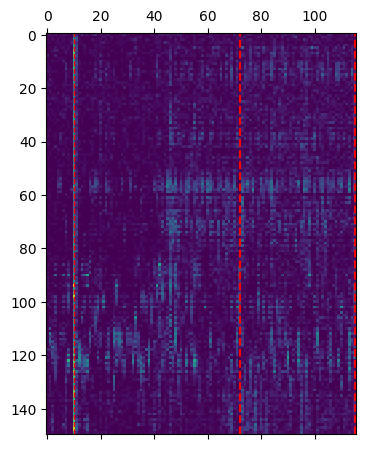

In [23]:
plt.matshow(model_data[0].T)
plt.axvline(cue, c="red", linestyle="--", lw=1)
plt.axvline(lift, c="red", linestyle="--")
plt.axvline(grab, c="red", linestyle="--")

# Design the input matrix

In [24]:
p_ids = np.unique(data["pattern_id"][0, behavior_idxs])

p_ids

array([14., 17., 20.])

## Get colors for plotting

In [25]:
c = {
    14: "blue",
    17: "orange",
    20: "green"
}

In [26]:
len(c)

3

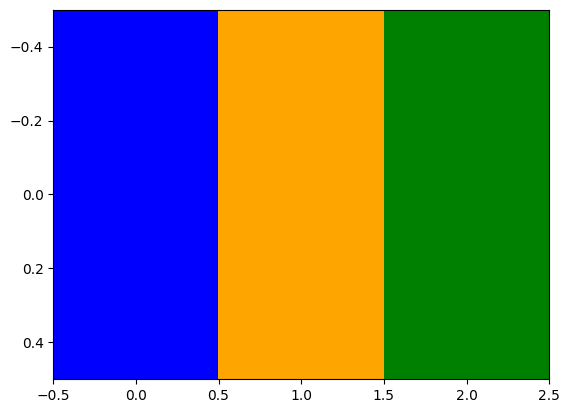

In [27]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(c.values())

plt.imshow(np.arange(len(c)).reshape(1,-1), aspect="auto", cmap=cmap)

# Create encodings 

In [28]:
import math

In [29]:
inputs = list()
colors = list()
for i, d in zip(stim_idxs, model_data):
    # get the pattern id 
    p_id = int(data["pattern_id"][0][i]) - 3

    colors.append(c[p_id + 3])

    encoding = all_patterns[p_id].ravel() 

    # stack the encoding for every timepoint (each bin)
    nput = np.zeros((d.shape[0], reshape_size**2))

    for z in range(math.ceil(5 / bin_size)):
        nput[int(50 / bin_size) + z] = encoding

    inputs.append(nput)

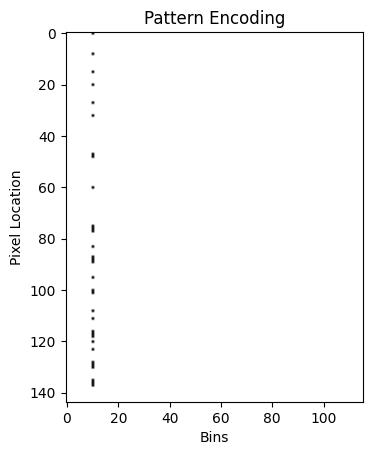

In [30]:
plt.imshow(inputs[0].T, cmap="binary")
plt.title("Pattern Encoding")
plt.xlabel("Bins")
plt.ylabel("Pixel Location")
plt.show()

# Fit the model

In [252]:
state_dim = 3
obs_dim = model_data[0].shape[1] 

plds = ssm.SLDS(N=obs_dim, 
                K=2, 
                D=state_dim, 
                M=144, 
                emissions="poisson", 
                emission_kwargs=dict(link="softplus"),
                dynamics="diagonal_gaussian",
                transitions="recurrent"
               )

elbos, q = plds.fit(model_data, inputs=inputs, method="laplace_em", num_iters=5)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [253]:
state_means = q.mean_continuous_states
len(state_means)

26

# Visualize a trial

In [446]:
trial_no = 0

In [447]:
behavior_idxs[0]

np.int64(18)

In [448]:
i = behavior_idxs[trial_no] + 1
# get video 
front_video = LazyVideo(video_path.joinpath(f"rb50_20250125_front_v0{i}.avi"))
side_video = LazyVideo(video_path.joinpath(f"rb50_20250125_side_v0{i}.avi"))
(front_video.shape, side_video.shape)

((2498, 290, 448), (2498, 290, 448))

In [449]:
fig = fpl.Figure(shape=(2,2), 
                 size=(800, 800), 
                 names=["front", "side", "binned_spikes", "z_t"], 
               #  cameras=["2d", "2d", "2d", "3d"]
                )

fig["front"].axes.visible = False
fig["front"].controller.enabled = False
fig["side"].axes.visible = False
fig["side"].controller.enabled = False
fig["binned_spikes"].axes.visible = False
fig["binned_spikes"].camera.maintain_aspect = False
fig["binned_spikes"].controller.enabled = False

RFBOutputContext()

In [450]:
front_graphic = fig["front"].add_image(front_video[0])
side_graphic = fig["side"].add_image(side_video[0])
heatmap = fig["binned_spikes"].add_image(model_data[trial_no].T, cmap="viridis")
ls = heatmap.add_linear_selector()
z_smooth = gaussian_filter1d(state_means[trial_no], 6, axis=0)
z_graphic = fig["z_t"].add_line(z_smooth)


/home/clewis/venvs/bah/lib64/python3.11/site-packages/fastplotlib/graphics/features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


In [451]:
cue = int(50 / bin_size)

lift = int(lift_times[trial_no, 0] / bin_size) + cue

grab = int(grab_times[trial_no, 0] / bin_size) + cue - 1
(lift, grab)

(72, 115)

In [452]:
# mark stim 
z_stim = fig["z_t"].add_scatter(z_smooth[cue].reshape(1,3), sizes=15, colors="blue")
# mark lift 
z_lift = fig["z_t"].add_scatter(z_smooth[lift].reshape(1,3), sizes=15, colors="green")
# mark grab 
z_grab = fig["z_t"].add_scatter(z_smooth[grab].reshape(1,3), sizes=15, colors="yellow")

# add tracer
z_point = fig["z_t"].add_scatter(z_smooth[0].reshape(1,3), sizes=15, colors="red")

In [453]:
slider = IntSlider(value=0, min=0, max=model_data[trial_no].shape[0]-1, layout=Layout(width="50%"))

In [454]:
selection = Select(
    options=list(behavior_idxs),
    value=behavior_idxs[0],
    # rows=10,
    description='Trial:',
    disabled=False,
    layout=Layout(width="25%")
)

In [455]:
def update(ev):
    global cue
    t = ev["new"] 

    # update linear selector in heatmap 
    ls.selection = t 

    # update scatter point selection 
    z_point.data = z_graphic.data[t].reshape(1,3)

    if t >= cue: 
        # update the video 
        s = ((t+-1) * 5) + 950
        s = math.ceil(s / 2)
        front_graphic.data = front_video[s]
        side_graphic.data = side_video[s]

    # output save for ffmpeg
    d = fig.canvas.snapshot().data
    pil_image = Image.fromarray(d, 'RGBA')
    pil_image.save(f'/home/clewis/Desktop/behavior/{t}.png')
    
        

In [456]:
def trial_change(ev):
    global heatmap
    global ls
    global z_graphic
    global z_stim 
    global z_lift 
    global z_grab
    global z_point
    
    i = ev["new"] 
    trial_no = np.where(behavior_idxs == i)[0][0]

    if i <= 8:
        i = f"00{i + 1}"
    elif i <= 98:
        i = f"0{i + 1}"
    else:
        i = f"{i + 1}"

    front_video = LazyVideo(video_path.joinpath(f"rb50_20250125_front_v{i}.avi"))
    side_video = LazyVideo(video_path.joinpath(f"rb50_20250125_side_v{i}.avi"))

    t = 0
    slider.value = t
    slider.max = model_data[trial_no].shape[0]-1
    front_graphic.data = front_video[t] 
    side_graphic.data = side_video[t] 

    fig["binned_spikes"].remove_graphic(heatmap)
    fig["binned_spikes"].remove_graphic(ls)
    
    heatmap = fig["binned_spikes"].add_image(model_data[trial_no].T, cmap="viridis")
    ls = heatmap.add_linear_selector()

    z_smooth = gaussian_filter1d(state_means[trial_no], 6, axis=0)

    fig["z_t"].remove_graphic(z_graphic)
    z_graphic = fig["z_t"].add_line(z_smooth)

    cue = int(50 / bin_size)

    lift = int(lift_times[trial_no, 0] / bin_size) + cue

    grab = int(grab_times[trial_no, 0] / bin_size) + cue - 1

    z_stim.data = z_smooth[cue].reshape(1,3)
    # mark lift 
    z_lift.data = z_smooth[lift].reshape(1,3)
    # mark grab 
    z_grab.data = z_smooth[grab].reshape(1,3)
    
    # add tracer
    z_point.data = z_smooth[0].reshape(1,3)

In [457]:
slider.observe(update, "value")

In [458]:
selection.observe(trial_change, "value")

In [459]:
VBox([HBox([fig.show(), selection]), slider])

In [350]:
np.where(behavior_idxs == 20)[0][0]

np.int64(1)

In [337]:
list(behavior_idxs)

[np.int64(18),
 np.int64(20),
 np.int64(23),
 np.int64(32),
 np.int64(37),
 np.int64(40),
 np.int64(42),
 np.int64(48),
 np.int64(55),
 np.int64(56),
 np.int64(60),
 np.int64(61),
 np.int64(67),
 np.int64(68),
 np.int64(70),
 np.int64(78),
 np.int64(83),
 np.int64(86),
 np.int64(97),
 np.int64(101),
 np.int64(103),
 np.int64(106),
 np.int64(118),
 np.int64(121),
 np.int64(128),
 np.int64(131)]

In [339]:
Select(
    options=list(behavior_idxs),
    value=behavior_idxs[0],
    # rows=10,
    description='Trial:',
    disabled=False
)

Select(description='Trial:', options=(np.int64(18), np.int64(20), np.int64(23), np.int64(32), np.int64(37), np…

# Integrating forward in time

In [226]:
lt = int(lift_times[0, 0] / bin_size) + 10
lt

72

In [228]:
gt = int(grab_times[0, 0] / bin_size) + 10 - lt

In [229]:
gt

44

In [230]:
zhist = plds.most_likely_states(state_means[0], model_data[0], inputs[0])[lt]
zhist

np.int64(0)

In [231]:
xhist = state_means[0][lt, :]
xhist

array([ -4.04342661, -29.29090859, -11.29538891])

In [232]:
yhist = model_data[0][lt].reshape(1, 150)
yhist

array([[ 2,  1,  2,  1,  0,  2,  0,  0,  1,  0,  2,  1,  1,  2,  0,  4,
         1,  1,  0,  1,  0,  0,  2,  1,  0,  1,  1,  2,  0,  1,  3,  0,
         4,  1,  1,  3,  2,  9,  0,  6,  4,  4,  5,  1,  1,  0,  4,  2,
         0,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  1,
         0,  0,  3,  0,  3,  2,  7,  5,  2,  3,  1,  9,  1,  2,  2,  6,
         0,  4,  0,  3,  3,  2,  2,  9, 10,  8, 13,  6,  7,  4,  7,  5,
         3, 10, 11,  7, 15,  7, 18,  9, 11,  4, 14, 14,  8,  6,  5,  0,
         3,  1,  3,  5,  3,  3,  1,  2,  0,  0,  0,  0,  2,  0,  4,  0,
         1,  6,  1,  0,  0,  1,  1,  6,  1,  5,  3,  0,  0,  3,  1,  0,
         0,  1,  0,  1,  0,  0]])

In [233]:
np.concatenate(([zhist], np.zeros(5, dtype=int)))

array([0, 0, 0, 0, 0, 0])

In [234]:
xhist.shape

(3,)

In [235]:
plds.D

3

In [236]:
a = plds.sample(gt, prefix=[zhist, xhist.reshape(1,3), yhist], with_noise=True)

In [237]:
a

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([[ 1.45983255e+01, -9.00879855e+00,  7.26309074e+00],
        [-2.22474039e-02,  3.99122257e+00, -1.79236104e+00],
        [-4.76278108e+00, -5.90568372e+00, -1.08651545e+01],
        [ 1.71811246e+01, -2.27244004e+01,  2.03553249e+01],
        [-1.25890459e+01, -2.68213758e+00, -1.62676824e+01],
        [ 1.43478889e+01,  3.18793802e+00, -4.24671680e+00],
        [ 3.35446161e+00, -7.30764695e-01, -9.24530806e+00],
        [ 2.00325094e+01, -1.60271543e+01, -1.67650529e+01],
        [ 1.13620608e+01,  9.37712935e-02, -1.91321835e+01],
        [ 1.39721073e+01,  1.02028303e+01, -3.29118650e+00],
        [ 1.81313358e+01, -4.30686230e+00, -3.68676559e+00],
        [ 2.13146576e+01,  4.74806395e+00, -1.13621817e+00],
        [ 1.26107642e+01, -7.57515764e+00, -3.43476004e+01],
        [ 1.73063347e+00, -7.44074700e+00, -9.96615823e+0

In [249]:
b = gaussian_filter1d(state_means[trial_no], 7, axis=0)[lt: lt+gt]
b.shape

(44, 3)

In [267]:
state_means[trial_no].shape

(116, 3)

In [277]:
a[1].shape

(44, 3)

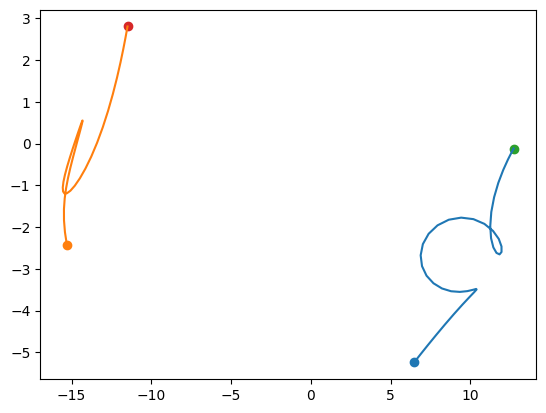

In [271]:
b = gaussian_filter1d(state_means[trial_no], 7, axis=0)[lt: lt+gt]
p = gaussian_filter1d(a[1], 5, axis=0)
plt.plot(p[:, 0], p[:, 1])
plt.plot(b[:, 0], b[:, 1])
plt.scatter(p[0, 0], p[0, 1])
plt.scatter(b[0, 0], b[0, 1])
plt.scatter(p[-1, 0], p[-1, 1])
plt.scatter(b[-1, 0], b[-1, 1])

In [272]:
state_means[trial_no].shape

(116, 3)

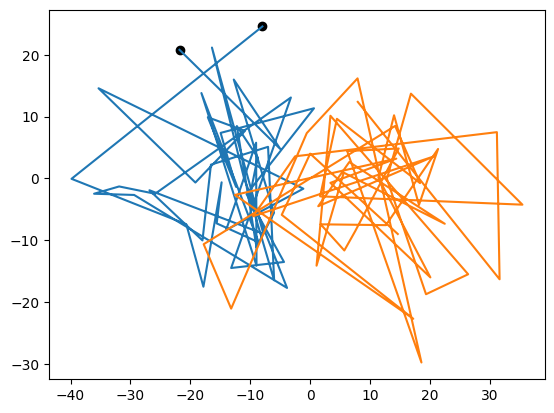

In [280]:
plt.plot(state_means[trial_no][lt:, 0], state_means[trial_no][lt:, 1])
plt.plot(a[1][:, 0], a[1][:, 1])
plt.scatter(state_means[trial_no][lt, 0], state_means[trial_no][lt, 1], c="black")
plt.scatter(state_means[trial_no][-1, 0], state_means[trial_no][-1, 1], c="black")

In [241]:
p.shape

(3, 44)